##Install Modules

In [ ]:
#General modules
import tensorflow as tf
import keras
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import os, pathlib
import tensorflow_datasets as tfds
import cv2
import seaborn as sns
import random

#Load the directory
from skimage.transform import resize
from skimage.io import imread

#Train & test the baseline model
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, recall_score, precision_score, f1_score, classification_report, confusion_matrix
from sklearn.ensemble import RandomForestClassifier
from sklearn import tree
from sklearn import svm, datasets
from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import RandomizedSearchCV

## Load the Directory

In [ ]:
#Connect to the directory
plasticimagedir = '/content/drive/MyDrive/Plastic_images_dir'
os.chdir(plasticimagedir)
!ls

augmented_classifier.png    LDPE		      PVC
checkpoint_path2.keras	    mobilenet_classifier.png  resnet_classifier.png
checkpoint_path.keras	    model_ensemble.pkl	      saved_model
cnn_classifier.png	    OTHER		      simple_classifier.png
efficientb7_classifier.png  PET
HDPE			    PP


## Pre-Process the Data

In [ ]:
#Categories of plastic types 
Categories=['HDPE', 'LDPE', 'OTHER', 'PET', 'PP', 'PVC']

#Image size
IMG_SIZE = 64

In [ ]:
#Code adapted from the following sources:
#1. https://www.kaggle.com/code/ashutoshvarma/image-classification-using-svm-92-accuracy
#2. https://medium.com/analytics-vidhya/image-classification-using-machine-learning-support-vector-machine-svm-dc7a0ec92e01

dataset_arr=[] #input array

#Loop through the categories
for i in Categories:
    print(f'loading... {i}') #display message to show that category is loading
    path=os.path.join(plasticimagedir,i) #join to the image directory
    class_index=Categories.index(i) #subdirectory name which is the inferred label
    class_len=len(os.listdir(path)) #get the number of files per category

    for img in os.listdir(path):
        try:
          img_array=cv2.imread(os.path.join(path,img))
          resized_array=cv2.resize(img_array,(IMG_SIZE, IMG_SIZE)) #resize images
          dataset_arr.append([resized_array,class_index])
        except Exception as e:
          pass
    print(f'loaded {i} successfully:', class_len) #display message to show that category has been loaded successfully

loading... HDPE
loaded HDPE successfully: 520
loading... LDPE
loaded LDPE successfully: 516
loading... OTHER
loaded OTHER successfully: 502
loading... PET
loaded PET successfully: 544
loading... PP
loaded PP successfully: 573
loading... PVC
loaded PVC successfully: 540


In [ ]:
random.shuffle(dataset_arr)

In [ ]:
lenofimage = len(dataset_arr)

X=[] #array to store the image data
y=[] #array to store the labels

#loop through the dataset array, and save the image data and labels into separate arrays
#remember in the intial for loop, we saved both the resized array and labels into the dataset array
for imgdata, label in dataset_arr:
    X.append(imgdata)
    y.append(label)

#Reshape the array - X should now be a Rank-2 tensor (matrix) 
# sklearn expects a 2D array as input to the fit() function which will be called on the model during training., the second being height*width*channels
X= np.array(X).reshape(lenofimage,-1)

#Normalise the array - maintain the pixels of all the images within a uniform range.
X = X/255.0
print(X.shape)

#Y should now be a Rank-1 tensor (vector) as it is just the name of the label
y=np.array(y)
print(y.shape)

(3195, 12288)
(3195,)


In [ ]:
#Split the data into testing and training data
x_train,x_test,y_train,y_test=train_test_split(X,y,test_size=0.20,random_state=77)

In [ ]:
#Create a support vector classifier
svc=svm.SVC(probability=False) #False = avoids applying expensive Platt's calibration internally

## Hyperparameter Tuning

In [ ]:
#Create a model through GridSearchCV and the parameters grid
param_grid={'C':[0.1,1,10,100]}
model=GridSearchCV(svc,param_grid)
#Fit the data - 21 minutes
model.fit(x_train, y_train)
model.best_estimator_

SVC(C=10)

In [ ]:
#Create a model through GridSearchCV and the parameters grid
param_grid_2={'gamma':[0.0001,0.001,0.1,1]}
model_2=GridSearchCV(svc,param_grid_2, cv=3, n_jobs = -1)
#Fit the data - 9 minutes
model_2.fit(x_train, y_train)
model_2.best_estimator_

SVC(gamma=0.001)

In [ ]:
#Create a model through GridSearchCV and the parameters grid
param_grid_3={'kernel':['rbf','poly', 'linear', 'sigmoid']}
model_3=GridSearchCV(svc,param_grid_3, cv=3, n_jobs = -1)
#Fit the data - 8 minutes
model_3.fit(x_train, y_train)
model_3.best_estimator_

SVC()

In [ ]:
param_grid_4={'kernel':['rbf','poly', 'linear', 'sigmoid'], 'gamma':[0.0001,0.001,0.1,1], 'C':[0.1,1,10,100]}
model_4=GridSearchCV(svc,param_grid_4, cv=3, n_jobs = -1)
#Fit the data - 8 minutes
model_4.fit(x_train, y_train)
model_4.best_estimator_

##Train and Test the Model

In [ ]:
#Train the data using Support Vector Machine
svmmodel = svm.SVC(C = 10, gamma = 0.001, kernel = 'rbf')

#Fit the data
svmmodel.fit(x_train, y_train)

#Test the dataset using the RandomForestClassifier
y_pred = svmmodel.predict(x_test)

In [ ]:
#print the metrics to give a baseline score
print('Training score:', svmmodel.score(x_train, y_train))
print('Accuracy:', accuracy_score(y_test, y_pred))
print('Recall:', recall_score(y_test, y_pred, average = 'weighted'))
print('Precision:', precision_score(y_test, y_pred, average='micro'))
print('F1_score:', f1_score(y_test, y_pred, average = 'macro'))

Training score: 0.9761345852895149
Accuracy: 0.7073552425665102
Recall: 0.7073552425665102
Precision: 0.7073552425665102
F1_score: 0.7068885540904845


In [ ]:
#print the classification report
print(classification_report(y_pred,y_test))

              precision    recall  f1-score   support

           0       0.76      0.65      0.70       123
           1       0.65      0.69      0.67       104
           2       0.61      0.75      0.67        81
           3       0.69      0.63      0.65       118
           4       0.77      0.81      0.79       107
           5       0.76      0.74      0.75       106

    accuracy                           0.71       639
   macro avg       0.71      0.71      0.71       639
weighted avg       0.71      0.71      0.71       639



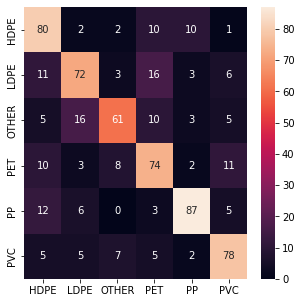

In [ ]:
#print the confusion matrix as an image
confmat = confusion_matrix(y_test, y_pred)
classes = Categories

#put the confusion matrix into a dataframe
df_confmat = pd.DataFrame(confmat, index = classes, columns = classes)

#plot the confusion matrix using a heatmap
plt.figure(figsize = (5,5))
confmat_plot = sns.heatmap(df_confmat, annot=True)

##Visualise the SVM

In [ ]:
from sklearn import datasets
from sklearn.datasets import load_sample_image
from sklearn.preprocessing import StandardScaler
from skimage import data, color, feature
from sklearn.decomposition import PCA

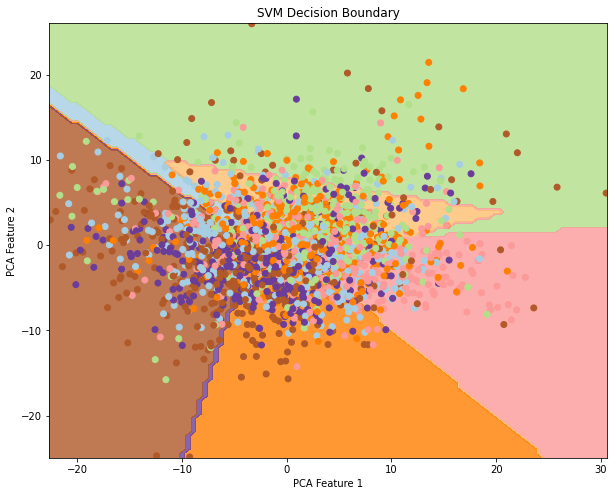

In [ ]:
#The code is adapted from a response by ChatGPT on the OpenAI platform.
#In this code, the PCA function from the sklearn.decomposition module is used to reduce the dimensionality of the training data to 2 dimensions. 
#The resulting 2D data is then used to train the SVM model using the same code as before. 
#Finally, the decision boundary and training data points are plotted using a scatter plot with the reduced PCA features on the x and y axes.

# Perform PCA to reduce the dimensionality of the data to 2 dimensions
pca = PCA(n_components=2)
X_train_pca = pca.fit_transform(x_train)

# Train the SVM model
pcamodel = svm.SVC(kernel='linear', C=0.001, decision_function_shape='ovr')
pcamodel.fit(X_train_pca, y_train)

# Create a mesh grid of points that cover the range of feature values in the training data
x_min, x_max = X_train_pca[:, 0].min() - 0.1, X_train_pca[:, 0].max() + 0.1
y_min, y_max = X_train_pca[:, 1].min() - 0.1, X_train_pca[:, 1].max() + 0.1
xx, yy = np.meshgrid(np.linspace(x_min, x_max, 100), np.linspace(y_min, y_max, 100))

# Use the trained SVM model to predict the class labels of each point in the mesh grid
Z = pcamodel.predict(np.c_[xx.ravel(), yy.ravel()])
Z = Z.reshape(xx.shape)

# Plot the decision boundary and training data points
plt.figure(figsize=(10, 8))
plt.contourf(xx, yy, Z, cmap=plt.cm.Paired, alpha=0.8)
plt.scatter(X_train_pca[:, 0], X_train_pca[:, 1], c=y_train, cmap=plt.cm.Paired)
plt.xlabel('PCA Feature 1')
plt.ylabel('PCA Feature 2')
plt.xlim(xx.min(), xx.max())
plt.ylim(yy.min(), yy.max())
plt.title('SVM Decision Boundary')
plt.show()

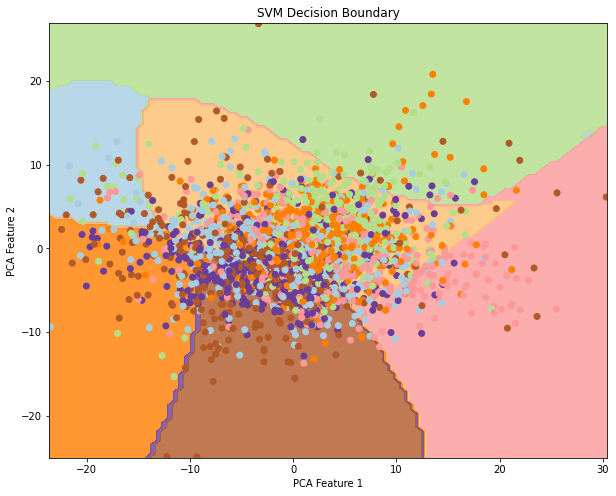

In [ ]:
from sklearn.decomposition import PCA

# Perform PCA on the image data to reduce the dimensionality to 2 components
pca_2 = PCA(n_components=2)
X_pca = pca_2.fit_transform(x_train)

# Create a mesh grid of points that cover the range of feature values in the PCA-transformed data
x_min, x_max = X_pca[:, 0].min() - 0.1, X_pca[:, 0].max() + 0.1
y_min, y_max = X_pca[:, 1].min() - 0.1, X_pca[:, 1].max() + 0.1
xx, yy = np.meshgrid(np.linspace(x_min, x_max, 100), np.linspace(y_min, y_max, 100))

# Use the trained SVM model to predict the class labels of each point in the mesh grid
Z = svmmodel.predict(pca_2.inverse_transform(np.c_[xx.ravel(), yy.ravel()]))
Z = Z.reshape(xx.shape)

# Plot the decision boundary and training data points
plt.figure(figsize=(10, 8))
plt.contourf(xx, yy, Z, cmap=plt.cm.Paired, alpha=0.8)
plt.scatter(X_pca[:, 0], X_pca[:, 1], c=y_train, cmap=plt.cm.Paired)
plt.xlabel('PCA Feature 1')
plt.ylabel('PCA Feature 2')
plt.xlim(xx.min(), xx.max())
plt.ylim(yy.min(), yy.max())
plt.title('SVM Decision Boundary')
plt.show()